# Explore the Data for Kaggle Parkinson's Prediction

https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_rows', None)

In [57]:
train_clin_df = pd.read_csv('../data/raw/train_clinical_data.csv')
train_prot_df = pd.read_csv('../data/raw/train_proteins.csv')
train_pep_df = pd.read_csv('../data/raw/train_peptides.csv')

test_df = pd.read_csv('../data/raw/test.csv')
test_prot_df = pd.read_csv('../data/raw/test_proteins.csv')
test_pep_df = pd.read_csv('../data/raw/test_peptides.csv')

sample_submission = pd.read_csv('../data/raw/sample_submission.csv')

### Check what the progression of the min and max UPDRs is like
Then look at if there are any proteins that are associated with the updrs that above the mean change

In [59]:
updrs_progression = train_clin_df.groupby(['patient_id'])['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'].max() - train_clin_df.groupby(['patient_id'])['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'].min()
updrs_progression.mean()

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


updrs_1     8.076613
updrs_2     7.040323
updrs_3    17.665323
updrs_4     4.207650
dtype: float64

In [60]:
# classify the patients into 3 groups based on the updrs progression
updrs_progression['updrs_1'] = pd.qcut(updrs_progression['updrs_1'], 3, labels=['low', 'medium', 'high'])
updrs_progression['updrs_2'] = pd.qcut(updrs_progression['updrs_2'], 3, labels=['low', 'medium', 'high'])
updrs_progression['updrs_3'] = pd.qcut(updrs_progression['updrs_3'], 3, labels=['low', 'medium', 'high'])

In [62]:
cat_updrs_progression = updrs_progression[['updrs_1', 'updrs_2', 'updrs_3']]


In [72]:
train_prot_pivot = train_prot_df.pivot(columns='Protein', values='NPX', index=['patient_id', 'visit_month'])
train_protein_mean = train_prot_pivot.groupby(['patient_id']).mean()
train_protein_diff = train_prot_pivot.groupby(['patient_id']).max() - train_prot_pivot.groupby(['patient_id']).min()

In [92]:
cat_updrs_diff_plot = cat_updrs_progression.merge(train_protein_diff, on='patient_id')

In [93]:
cat_updrs_diff_updr1 = cat_updrs_diff_plot.drop(columns=['updrs_2', 'updrs_3'])
cat_updrs_diff_updr2 = cat_updrs_diff_plot.drop(columns=['updrs_1', 'updrs_3'])
cat_updrs_diff_updr3 = cat_updrs_diff_plot.drop(columns=['updrs_1', 'updrs_2'])

In [94]:
#replace high with 10, medium with 5 and low with 0
cat_updrs_diff_updr1 = cat_updrs_diff_updr1.replace({'high': 10, 'medium': 5, 'low': 0})
cat_updrs_diff_updr2 = cat_updrs_diff_updr2.replace({'high': 10, 'medium': 5, 'low': 0})
cat_updrs_diff_updr3 = cat_updrs_diff_updr3.replace({'high': 10, 'medium': 5, 'low': 0})

## Look for Correlations with the Protein Means and the UPDRs scores

In [98]:

# get the correlations between the updrs progression and the proteins
cat_updrs_diff_updr1.corr()['updrs_1'].sort_values(ascending=False)

updrs_1    1.000000
P61916     0.170089
P08697     0.168615
P20774     0.108141
P01861     0.105472
P01008     0.104732
P02751     0.101731
P07602     0.098678
P02766     0.096223
Q12805     0.093460
Q9UBX5     0.093401
P01033     0.092607
P54289     0.089122
P27169     0.088646
P06727     0.087693
O14773     0.085434
P13591     0.085283
P36955     0.085187
P06310     0.082608
P02790     0.079955
P01023     0.079188
Q8NBJ4     0.076730
P08493     0.076224
P01042     0.075059
P32754     0.072241
P10643     0.069889
P00734     0.069533
P02774     0.065049
P01857     0.062021
P04180     0.059473
P05546     0.059444
P02749     0.059114
P01833     0.057712
P00747     0.055361
P23142     0.054336
P09871     0.054266
P04196     0.053857
P05155     0.053832
P13521     0.052857
P02765     0.052602
Q16270     0.050745
P01594     0.050046
P08603     0.049971
P43121     0.047210
P60174     0.046465
P12109     0.044145
Q12841     0.043982
P01019     0.042655
P02675     0.042172
Q92876     0.041884


In [102]:
train_pep_df.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [103]:
train_pep_pivot = train_pep_df.pivot(columns='Peptide', values='PeptideAbundance', index=['patient_id', 'visit_month'])
train_pep_mean = train_pep_pivot.groupby(['patient_id']).mean()
train_pep_diff = train_pep_pivot.groupby(['patient_id']).max() - train_pep_pivot.groupby(['patient_id']).min()

In [104]:
cat_updrs_diff_plot = cat_updrs_progression.merge(train_pep_diff, on='patient_id')


cat_updrs_diff_updr1 = cat_updrs_diff_plot.drop(columns=['updrs_2', 'updrs_3'])
cat_updrs_diff_updr2 = cat_updrs_diff_plot.drop(columns=['updrs_1', 'updrs_3'])
cat_updrs_diff_updr3 = cat_updrs_diff_plot.drop(columns=['updrs_1', 'updrs_2'])

In [105]:
#replace high with 10, medium with 5 and low with 0
cat_updrs_diff_updr1 = cat_updrs_diff_updr1.replace({'high': 10, 'medium': 5, 'low': 0})
cat_updrs_diff_updr2 = cat_updrs_diff_updr2.replace({'high': 10, 'medium': 5, 'low': 0})
cat_updrs_diff_updr3 = cat_updrs_diff_updr3.replace({'high': 10, 'medium': 5, 'low': 0})

In [110]:
# get the correlations between the updrs progression and the proteins
cat_updrs_diff_updr3.corr()['updrs_3'].sort_values(ascending=False)

updrs_3                                                                                    1.000000
EPQVYTLPPSRDELTK                                                                           0.281868
HYTNPSQDVTVPC(UniMod_4)PVPPPPPC(UniMod_4)C(UniMod_4)HPR                                    0.184300
QTHQPPAPNSLIR                                                                              0.172443
KC(UniMod_4)C(UniMod_4)VEC(UniMod_4)PPC(UniMod_4)PAPPVAGPSVFLFPPKPK                        0.165136
FQSVFTVTR                                                                                  0.160086
AVDTWSWGER                                                                                 0.159857
HYEGSTVPEK                                                                                 0.152982
NSLFEYQK                                                                                   0.147155
DSGEGDFLAEGGGVR                                                                            0.137516


In [3]:
test_df.head()

,visit_id,visit_month,patient_id,updrs_test,row_id,group_key
0,3342_0,0,3342,updrs_1,3342_0_updrs_1,0
1,3342_0,0,3342,updrs_2,3342_0_updrs_2,0
2,3342_0,0,3342,updrs_3,3342_0_updrs_3,0
3,3342_0,0,3342,updrs_4,3342_0_updrs_4,0
4,50423_0,0,50423,updrs_1,50423_0_updrs_1,0


In [4]:
test_prot_df.head()

,visit_id,visit_month,patient_id,UniProt,NPX,group_key
0,50423_0,0,50423,O00391,33127.90,0
1,50423_0,0,50423,O00533,490742.00,0
2,50423_0,0,50423,O00584,43615.30,0
3,50423_0,0,50423,O14773,16486.60,0
4,50423_0,0,50423,O14791,2882.42,0


In [5]:
test_prot_df['visit_month'].value_counts()

0    227
6    226
Name: visit_month, dtype: int64

In [6]:
test_prot_df.groupby(['patient_id'])['visit_month'].unique()

patient_id
3342     [6]
50423    [0]
Name: visit_month, dtype: object

### Test Protein Data

There is only one visit month per patient in this test_df. As well, that visit month is not always 0. Something to be thoughtful of in creating the training set.

In [7]:
test_pep_df.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,group_key
0,50423_0,0,50423,O00391,AHFSPSNIILDFPAAGSAAR,22226.3,0
1,50423_0,0,50423,O00391,NEQEQPLGQWHLS,10901.6,0
2,50423_0,0,50423,O00533,GNPEPTFSWTK,51499.4,0
3,50423_0,0,50423,O00533,IEIPSSVQQVPTIIK,125492.0,0
4,50423_0,0,50423,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,23174.2,0


In [8]:
test_pep_df['visit_month'].value_counts()

6    1036
0    1021
Name: visit_month, dtype: int64

In [9]:
test_prot_df.groupby(['patient_id'])['visit_month'].unique()

patient_id
3342     [6]
50423    [0]
Name: visit_month, dtype: object

### Test Peptide Data

There is only one month per patient in the peptide data which corresponds with the protein data which makes sense.

In [10]:
sample_submission.shape

(64, 3)

In [11]:
sample_submission

,prediction_id,rating,group_key
0,3342_0_updrs_1_plus_0_months,0,0
1,3342_0_updrs_1_plus_6_months,0,0
2,3342_0_updrs_1_plus_12_months,0,0
3,3342_0_updrs_1_plus_24_months,0,0
4,3342_0_updrs_2_plus_0_months,0,0
5,3342_0_updrs_2_plus_6_months,0,0
6,3342_0_updrs_2_plus_12_months,0,0
7,3342_0_updrs_2_plus_24_months,0,0
8,3342_0_updrs_3_plus_0_months,0,0
9,3342_0_updrs_3_plus_6_months,0,0


### Description of the sample submission:
- prediction_id: the row id, updrs number, and the number of months later predicting
- rating: the prediction value of the updrs
- group_key: looks to be the last number of the row id, which is the visit month

#### The sample submission is requesting predictions on row id 3342_0 which does not have any protein data associated with it. That is very surprising.

## Training Data

In [12]:
train_clin_df.head(20)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
5,55_18,55,18,7.0,13.0,38.0,0.0,On
6,55_24,55,24,16.0,9.0,49.0,0.0,On
7,55_30,55,30,14.0,13.0,49.0,0.0,On
8,55_36,55,36,17.0,18.0,51.0,0.0,On
9,55_42,55,42,12.0,20.0,41.0,0.0,On


In [13]:
train_clin_df['upd23b_clinical_state_on_medication'].value_counts()

On     775
Off    513
Name: upd23b_clinical_state_on_medication, dtype: int64

In [14]:
train_clin_df['upd23b_clinical_state_on_medication'].isna().sum() / train_clin_df.shape[0]

0.5074569789674952

### Upd23b medication

There are 50% of the samples have NaN for the medication. This feature may be something to exclude.

In [15]:
train_clin_df[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].isna().sum() / train_clin_df.shape[0]

updrs_1    0.000382
updrs_2    0.000765
updrs_3    0.009560
updrs_4    0.396941
dtype: float64

### UPDRs NaN values

UPDRs 4 has 40% missing values.

- Can these values be imputed from anothe updrs that is highly correlated?

In [16]:
train_clin_df[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].corr()

,updrs_1,updrs_2,updrs_3,updrs_4
updrs_1,1.000000,0.661802,0.434569,0.432620
updrs_2,0.661802,1.000000,0.735106,0.383866
updrs_3,0.434569,0.735106,1.000000,0.221593
updrs_4,0.432620,0.383866,0.221593,1.000000


### No Major UPDR 4 correlation

Based on simple correlation there is no way to impute the missing values

## Use ML to impute the UPDRs 4 missing values

In [17]:
rf_imputer = RandomForestRegressor()


train_data = train_clin_df.dropna()

# drop the null value rows of updrs_1, 2, 3 since it is needed for imputing
to_impute_data = train_clin_df.dropna(subset=['updrs_1', 'updrs_2', 'updrs_3'])
to_impute_data = to_impute_data[to_impute_data['updrs_4'].isna()]

impute_trainer = train_data[train_data['updrs_4'].notnull()]

rf_imputer.fit(impute_trainer[['updrs_1', 'updrs_2', 'updrs_3']], impute_trainer[['updrs_4']])

impute_values = rf_imputer.predict(to_impute_data[['updrs_1', 'updrs_2', 'updrs_3']])

to_impute_data['updrs_4'] = [round(x) for x in impute_values]

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


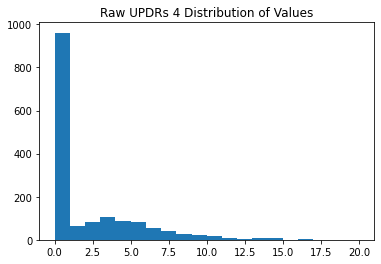

In [18]:
plt.hist(train_clin_df['updrs_4'], bins=20)
plt.title('Raw UPDRs 4 Distribution of Values')
plt.show()

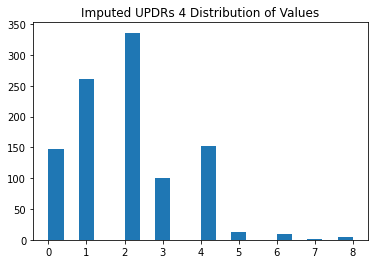

In [19]:
plt.hist(to_impute_data['updrs_4'], bins=20)
plt.title('Imputed UPDRs 4 Distribution of Values')
plt.show()

## Imputed UPDRs 4

The imputed values of UPDRs 4 are mostly between 0 and 2 but has far too many 1 values compared to the raw updrs. It may be better to look if there is a protein expressed that correlates highly with the non zero values.

In [20]:
# create a column with the UniProt and Peptide name combined
train_pep_df['peptide_uniprot'] = train_pep_df['Peptide'] + '_'+ train_pep_df['UniProt']
train_pep_df.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,peptide_uniprot
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3,NEQEQPLGQWHLS_O00391
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0,GNPEPTFSWTK_O00533
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0,IEIPSSVQQVPTIIK_O00533
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK_O00533
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7,SMEQNGPGLEYR_O00533


In [21]:
# create a table with the visit_id as the index and the proteins or peptides as the feature and the abundance as the values
train_prot_pivot = train_prot_df.pivot(index='visit_id', values='NPX', columns='UniProt')
train_pep_pivot = train_pep_df.pivot(index='visit_id', values='PeptideAbundance', columns='peptide_uniprot')

In [22]:
# combine the two tables on the visit_id
full_prot_train_df = train_prot_pivot.join(train_pep_pivot)
full_prot_train_df = full_prot_train_df.reset_index(drop=True)
full_prot_train_df.head()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YSLTYIYTGLSK_P25311,YTTEIIK_P00736,YVGGQEHFAHLLILR_P02763,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738,YVMLPVADQDQC(UniMod_4)IR_P00738,YVNKEIQNAVNGVK_P10909,YWGVASFLQK_P02753,YYC(UniMod_4)FQGNQFLR_P02790,YYTYLIMNK_P01024,YYWGGQYTWDMAK_P02675
0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,129048.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,108114.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,163776.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,56725.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,85767.1,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09


In [23]:
# fill nan with 0 for this first round
full_prot_train_df = full_prot_train_df.fillna(0)

In [24]:
train_prot_pivot = train_prot_pivot.reset_index()

train_prot_pivot.head()

UniProt,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,NaN,9469.45,94237.6,NaN,23016.0,177983.0,65900.0,15382.0,NaN,19017.40
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,NaN,14408.40,NaN,NaN,28537.0,171733.0,65668.1,NaN,9295.65,25697.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,317477.0,38667.20,111107.0,NaN,37932.6,245188.0,59986.1,10813.3,NaN,29102.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,557904.0,44556.90,155619.0,14647.9,36927.7,229232.0,106564.0,26077.7,21441.80,7642.42
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,NaN,47836.70,177619.0,17061.1,25510.4,176722.0,59471.4,12639.2,15091.40,6168.55


In [25]:
train_prot_pivot = train_prot_pivot.fillna(0)

# merge the protein data and the clinical data
train_clin_prot = train_clin_df.merge(train_prot_pivot, on='visit_id', how='left')

In [26]:
train_clin_prot.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,11254.3,732430.0,...,365475.0,35528.0,97005.6,23122.5,60912.6,408698.0,0.0,29758.8,23833.7,18953.5
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,13163.6,630465.0,...,405676.0,30332.6,109174.0,23499.8,51655.8,369870.0,0.0,22935.2,17722.5,16642.7
3,55_9,55,9,8.0,9.0,30.0,0.0,On,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55_12,55,12,10.0,10.0,41.0,0.0,On,15257.6,815083.0,...,303953.0,43026.2,114921.0,21860.1,61598.2,318553.0,65762.6,29193.4,28536.1,19290.9


In [27]:
# look for a correlation between the updrs_4 and the proteins
updrs_4_corr = train_clin_prot.corr()['updrs_4'].sort_values(ascending=False)
updrs_4_corr[:20]

updrs_4        1.000000
updrs_1        0.432620
updrs_2        0.383866
updrs_3        0.221593
visit_month    0.138013
P23083         0.124741
P31997         0.102361
P43251         0.089153
P16152         0.087579
P19827         0.082150
P01594         0.078567
P04275         0.076342
P55290         0.071613
P14314         0.071270
Q7Z5P9         0.062275
Q9UNU6         0.061301
Q6UX71         0.050691
O75144         0.050257
O94919         0.046582
O00391         0.045957
Name: updrs_4, dtype: float64

In [28]:
def imputer_updrs(val):
    if val == 0:
        return 0
    elif val > 0:
        return 1
    else:
        return np.nan

In [29]:
# can the updrs_4 be classified as 0 or greater than 0 
train_clin_prot['updrs_4_value_0'] = train_clin_prot['updrs_4'].apply(imputer_updrs)

In [30]:
# look for a correlation between the updrs_4_value_0 and the proteins
updrs_4_cat_corr = train_clin_prot.corr()['updrs_4_value_0'].sort_values(ascending=False)
updrs_4_cat_corr[:20]

updrs_4_value_0    1.000000
updrs_4            0.769702
updrs_1            0.336749
updrs_2            0.324829
visit_month        0.239479
updrs_3            0.219840
P43251             0.110328
P02655             0.077979
P19827             0.073717
P31997             0.071600
P04275             0.066442
P02765             0.065464
P11277             0.058547
P23083             0.054157
P55290             0.050317
Q7Z5P9             0.045373
P16152             0.039239
P04004             0.031860
Q9UNU6             0.030273
P02766             0.029575
Name: updrs_4_value_0, dtype: float64

In [31]:
# train a random forest classifier to predict the updrs_4_value_0
rf_clf = RandomForestClassifier()

# drop nan values for updrs_4
train_impute_prot = train_clin_prot.dropna(subset=['updrs_4', 'updrs_1', 'updrs_2', 'updrs_3'])
train_impute_prot = train_impute_prot.fillna(0)
train_impute_df  = train_impute_prot.drop(columns=['patient_id', 'visit_id', 'upd23b_clinical_state_on_medication'])
train_cols = train_impute_df.columns


# train the classifier
rf_clf.fit(train_impute_prot.drop(columns=['patient_id', 'visit_id', 'upd23b_clinical_state_on_medication']), train_impute_prot['updrs_4_value_0'])

RandomForestClassifier()

In [32]:
impute_df = train_clin_prot.dropna(subset=['updrs_1', 'updrs_2', 'updrs_3'])
impute_df = impute_df[impute_df['updrs_4'].isna()]

impute_X = impute_df.drop(columns=['patient_id', 'visit_id', 'upd23b_clinical_state_on_medication', 'updrs_4', 'updrs_4_value_0'])
fill_cols = [x for x in train_cols if x not in impute_X.columns]
fill_df = pd.DataFrame(columns=fill_cols)
impute_X = pd.concat([impute_X, fill_df], axis=1)
impute_X = impute_X.fillna(0)

impute_values = rf_clf.predict(impute_X[train_cols])

In [33]:
impute_df['updrs_4_pred'] = impute_values
impute_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,...,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,updrs_4_value_0,updrs_4_pred
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,11254.3,732430.0,...,97005.6,23122.5,60912.6,408698.0,0.0,29758.8,23833.7,18953.5,NaN,0.0
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,13163.6,630465.0,...,109174.0,23499.8,51655.8,369870.0,0.0,22935.2,17722.5,16642.7,NaN,0.0
13,942_0,942,0,3.0,2.0,20.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
14,942_3,942,3,7.0,2.0,17.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [34]:
impute_df['updrs_4_pred'].value_counts()

0.0    1026
Name: updrs_4_pred, dtype: int64

## Imputer Results
Looks like all imputed values are 0 using the Random Forest

## Arange the Data from Different visit month predictions

Get the visit month 0 for each updrs since that will be the first prediction column target. And the protein data might come from visit_month 6 or 12 or 3, and still have to predict visit month 0 updrs.

In [35]:
month_0_cols = ['updrs_1_0_month' , 'updrs_2_0_month', 'updrs_3_0_month']

month_0_df = train_clin_df[train_clin_df['visit_month'] == 0][['patient_id','updrs_1', 'updrs_2', 'updrs_3']]

In [36]:
month_0_df.columns = ['patient_id'] + month_0_cols

train_clin_df = train_clin_df.merge(month_0_df, on='patient_id', how='left')

In [37]:
train_clin_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,updrs_1_0_month,updrs_2_0_month,updrs_3_0_month
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,10.0,6.0,15.0
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,10.0,6.0,15.0
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,10.0,6.0,15.0
3,55_9,55,9,8.0,9.0,30.0,0.0,On,10.0,6.0,15.0
4,55_12,55,12,10.0,10.0,41.0,0.0,On,10.0,6.0,15.0


In [38]:
# drop the updrs columns since this data will be used strictly for predicting visit 0
train_clin_df = train_clin_df.drop(columns=['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'upd23b_clinical_state_on_medication'])

In [40]:
# merge the protein data and the clinical data
full_train_df = train_clin_df.merge(train_prot_pivot, on='visit_id', how='right')

# merge the peptide data and the clinical data
full_train_df = full_train_df.merge(train_pep_pivot, on='visit_id', how='right')

### Use the right join to eliminate any clinic visits that did not have the protein and peptides taken

### Try Random Forrest Regressor to start on updrs_1 only

target column will be updrs_1 and training data will be all the peptide and protein data.

visit_month, patient_id, and visit_month will all be excluded

#### Perform KFold Cross Validation on the Data for the Model

In [41]:
# randomize the rows
full_train_df = full_train_df.sample(frac=1).reset_index(drop=True)
full_train_df.head()

,visit_id,patient_id,visit_month,updrs_1_0_month,updrs_2_0_month,updrs_3_0_month,O00391,O00533,O00584,O14498,...,YSLTYIYTGLSK_P25311,YTTEIIK_P00736,YVGGQEHFAHLLILR_P02763,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738,YVMLPVADQDQC(UniMod_4)IR_P00738,YVNKEIQNAVNGVK_P10909,YWGVASFLQK_P02753,YYC(UniMod_4)FQGNQFLR_P02790,YYTYLIMNK_P01024,YYWGGQYTWDMAK_P02675
0,57478_0,57478.0,0.0,6.0,3.0,11.0,0.0,410448.0,19021.20,25201.5,...,217468.0,9014.02,3162940.0,24405.3,132960.0,113977.000,102673.0,425555.0,30487.5,19667.3
1,20581_48,20581.0,48.0,7.0,0.0,4.0,11377.7,601448.0,33762.50,29308.8,...,248783.0,11304.90,3224660.0,21697.3,309193.0,96426.900,201997.0,436763.0,53640.9,NaN
2,17727_24,17727.0,24.0,3.0,0.0,1.0,14010.8,624614.0,22346.50,20926.0,...,140340.0,NaN,2192040.0,NaN,310973.0,72457.700,174950.0,520421.0,NaN,NaN
3,56691_36,56691.0,36.0,1.0,0.0,0.0,10455.1,365905.0,8982.28,33669.3,...,201259.0,9486.49,2913780.0,107863.0,712204.0,90982.200,96915.0,644752.0,38034.9,10040.6
4,49683_0,49683.0,0.0,4.0,0.0,0.0,12767.4,381937.0,24041.10,15007.9,...,114936.0,14679.50,447161.0,23643.3,139648.0,869.898,157871.0,279388.0,102646.0,NaN


In [42]:
full_train_df.shape

(1113, 1201)

In [43]:
full_train_df['updrs_1_0_month'].isna().sum()

45

In [44]:
# calculate the number of bins by Sturge's rule
num_bins = int(np.floor(1 + np.log2(len(full_train_df))))
print(num_bins)

11


In [45]:
# bin the target updrs_1
full_train_df.loc[:, "bins"] = pd.cut(full_train_df['updrs_1_0_month'], bins=num_bins, labels=False)
full_train_df['bins'].head()

0    3.0
1    3.0
2    1.0
3    0.0
4    2.0
Name: bins, dtype: float64

In [46]:
full_train_df.head()

,visit_id,patient_id,visit_month,updrs_1_0_month,updrs_2_0_month,updrs_3_0_month,O00391,O00533,O00584,O14498,...,YTTEIIK_P00736,YVGGQEHFAHLLILR_P02763,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738,YVMLPVADQDQC(UniMod_4)IR_P00738,YVNKEIQNAVNGVK_P10909,YWGVASFLQK_P02753,YYC(UniMod_4)FQGNQFLR_P02790,YYTYLIMNK_P01024,YYWGGQYTWDMAK_P02675,bins
0,57478_0,57478.0,0.0,6.0,3.0,11.0,0.0,410448.0,19021.20,25201.5,...,9014.02,3162940.0,24405.3,132960.0,113977.000,102673.0,425555.0,30487.5,19667.3,3.0
1,20581_48,20581.0,48.0,7.0,0.0,4.0,11377.7,601448.0,33762.50,29308.8,...,11304.90,3224660.0,21697.3,309193.0,96426.900,201997.0,436763.0,53640.9,NaN,3.0
2,17727_24,17727.0,24.0,3.0,0.0,1.0,14010.8,624614.0,22346.50,20926.0,...,NaN,2192040.0,NaN,310973.0,72457.700,174950.0,520421.0,NaN,NaN,1.0
3,56691_36,56691.0,36.0,1.0,0.0,0.0,10455.1,365905.0,8982.28,33669.3,...,9486.49,2913780.0,107863.0,712204.0,90982.200,96915.0,644752.0,38034.9,10040.6,0.0
4,49683_0,49683.0,0.0,4.0,0.0,0.0,12767.4,381937.0,24041.10,15007.9,...,14679.50,447161.0,23643.3,139648.0,869.898,157871.0,279388.0,102646.0,NaN,2.0


In [47]:
full_train_df = full_train_df.dropna(subset=['bins'])
full_train_df = full_train_df.reset_index()

In [48]:
# initiate the kfold class from sklearn
kf = StratifiedKFold(n_splits=5)

In [49]:
# create a kfold column
full_train_df['kfold'] = -1

# fill the kfold column
for f, (t_, v_) in enumerate(kf.split(X=full_train_df, y=full_train_df['bins'].values)):
    full_train_df.loc[v_, 'kfold'] = f

In [50]:
# drop the bins column
full_train_df = full_train_df.drop('bins', axis=1)


In [51]:
full_train_df.head()

,index,visit_id,patient_id,visit_month,updrs_1_0_month,updrs_2_0_month,updrs_3_0_month,O00391,O00533,O00584,...,YTTEIIK_P00736,YVGGQEHFAHLLILR_P02763,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738,YVMLPVADQDQC(UniMod_4)IR_P00738,YVNKEIQNAVNGVK_P10909,YWGVASFLQK_P02753,YYC(UniMod_4)FQGNQFLR_P02790,YYTYLIMNK_P01024,YYWGGQYTWDMAK_P02675,kfold
0,0,57478_0,57478.0,0.0,6.0,3.0,11.0,0.0,410448.0,19021.20,...,9014.02,3162940.0,24405.3,132960.0,113977.000,102673.0,425555.0,30487.5,19667.3,0
1,1,20581_48,20581.0,48.0,7.0,0.0,4.0,11377.7,601448.0,33762.50,...,11304.90,3224660.0,21697.3,309193.0,96426.900,201997.0,436763.0,53640.9,NaN,0
2,2,17727_24,17727.0,24.0,3.0,0.0,1.0,14010.8,624614.0,22346.50,...,NaN,2192040.0,NaN,310973.0,72457.700,174950.0,520421.0,NaN,NaN,0
3,3,56691_36,56691.0,36.0,1.0,0.0,0.0,10455.1,365905.0,8982.28,...,9486.49,2913780.0,107863.0,712204.0,90982.200,96915.0,644752.0,38034.9,10040.6,0
4,4,49683_0,49683.0,0.0,4.0,0.0,0.0,12767.4,381937.0,24041.10,...,14679.50,447161.0,23643.3,139648.0,869.898,157871.0,279388.0,102646.0,NaN,0


In [52]:
full_train_df.shape

(1068, 1203)

In [53]:
train_csv_df = full_train_df.drop(columns=['kfold'])
train_csv_df.to_csv('../data/processed/train_data_visit0.csv', index=False)

,visit_id,patient_id,visit_month,updrs_1_0_month,updrs_2_0_month,updrs_3_0_month
0,55_0,55,0,10.0,6.0,15.0
1,55_3,55,3,10.0,6.0,15.0
2,55_6,55,6,10.0,6.0,15.0
3,55_9,55,9,10.0,6.0,15.0
4,55_12,55,12,10.0,6.0,15.0


In [ ]:
def calculate_smape(y_true, y_pred):

    return round(np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2)) * 100, 2)

In [172]:
def rf_cv_model(df, target):
    
    final_smape = list()
    
    df = df.fillna(0)
    
    for fold in df['kfold'].unique():
        print(f'Target: {target}')
        print(f'Fold: {fold}')
        kfold = fold
        

        val_df = df[df['kfold'] == kfold].reset_index(drop=True)
        train_df = df[df['kfold'] != kfold].reset_index(drop=True)
        
        updr_list = ['updrs_1_0_month', 'updrs_2_0_month', 'updrs_3_0_month']
        drop_list = ['visit_id', 'patient_id'] + updr_list
    
        y_train = train_df[[target]]
        X_train = train_df.drop(drop_list, axis=1)
        y_val = val_df[[target]]
        X_val = val_df.drop(drop_list, axis=1)

        rf = RandomForestRegressor()

        rf.fit(X_train.values, y_train.values.ravel()) 

        val_preds = rf.predict(X_val.values)
        smape = calculate_smape(y_val.values.ravel(), val_preds)
        r2 = r2_score(y_val.values.ravel(), val_preds)
        
        print(f'SMAPE: {smape}')
        print(f'R-squared: {r2}\n')
        
        final_smape.append(smape)
        
    print('Average SMAPE:', np.mean(final_smape))

In [173]:
for updr in ['updrs_1_0_month', 'updrs_2_0_month', 'updrs_3_0_month']:
    rf_cv_model(full_train_df, updr)

Target: updrs_1_0_month
Fold: 0
SMAPE: 65.99
R-squared: 0.2560271118943538

Target: updrs_1_0_month
Fold: 1
SMAPE: 65.41
R-squared: 0.3702934977597574

Target: updrs_1_0_month
Fold: 2
SMAPE: 66.52
R-squared: 0.2273977019846497

Target: updrs_1_0_month
Fold: 3
SMAPE: 62.75
R-squared: 0.3914526391294759

Target: updrs_1_0_month
Fold: 4
SMAPE: 68.81
R-squared: 0.26493486848008607

Average SMAPE: 65.89599999999999
Target: updrs_2_0_month
Fold: 0
SMAPE: 87.55
R-squared: 0.22782556382474362

Target: updrs_2_0_month
Fold: 1
SMAPE: 92.39
R-squared: 0.3140963293654887

Target: updrs_2_0_month
Fold: 2
SMAPE: 91.51
R-squared: 0.2455440114211449

Target: updrs_2_0_month
Fold: 3
SMAPE: 90.75
R-squared: 0.3341485025449773

Target: updrs_2_0_month
Fold: 4
SMAPE: 85.76
R-squared: 0.32129855167945276

Average SMAPE: 89.592
Target: updrs_3_0_month
Fold: 0
SMAPE: 74.43
R-squared: 0.29436241886232206

Target: updrs_3_0_month
Fold: 1
SMAPE: 79.94
R-squared: 0.2966668072792292

Target: updrs_3_0_month
Fold:

### Try XGBoost Regressor

In [176]:

import xgboost

def xgboost_cv_model(df, target):

    final_smape = list()
    
    df = df.fillna(0)
    
    for fold in df['kfold'].unique():
        print(f'Target: {target}')
        print(f'Fold: {fold}')
        kfold = fold
        

        val_df = df[df['kfold'] == kfold].reset_index(drop=True)
        train_df = df[df['kfold'] != kfold].reset_index(drop=True)
        
        updr_list = ['updrs_1_0_month', 'updrs_2_0_month', 'updrs_3_0_month']
        drop_list = ['visit_id', 'patient_id'] + updr_list
    
        y_train = train_df[[target]]
        X_train = train_df.drop(drop_list, axis=1)
        y_val = val_df[[target]]
        X_val = val_df.drop(drop_list, axis=1)

        xgb = xgboost.XGBRegressor()

        xgb.fit(X_train.values, y_train.values.ravel()) 

        val_preds = xgb.predict(X_val.values)
        smape = calculate_smape(y_val.values.ravel(), val_preds)
    
        print(f'SMAPE: {smape}\n')
        
        final_smape.append(smape)
        
    print('Average SMAPE:', np.mean(final_smape))

In [177]:
for updr in ['updrs_1_0_month', 'updrs_2_0_month', 'updrs_3_0_month']:
    xgboost_cv_model(full_train_df, updr)

Target: updrs_1_0_month
Fold: 0
SMAPE: 64.56

Target: updrs_1_0_month
Fold: 1
SMAPE: 63.22

Target: updrs_1_0_month
Fold: 2
SMAPE: 64.54

Target: updrs_1_0_month
Fold: 3
SMAPE: 62.13

Target: updrs_1_0_month
Fold: 4
SMAPE: 67.32

Average SMAPE: 64.354
Target: updrs_2_0_month
Fold: 0
SMAPE: 87.16

Target: updrs_2_0_month
Fold: 1
SMAPE: 98.6

Target: updrs_2_0_month
Fold: 2
SMAPE: 91.02

Target: updrs_2_0_month
Fold: 3
SMAPE: 91.63

Target: updrs_2_0_month
Fold: 4
SMAPE: 88.39

Average SMAPE: 91.35999999999999
Target: updrs_3_0_month
Fold: 0
SMAPE: 74.81

Target: updrs_3_0_month
Fold: 1
SMAPE: 83.26

Target: updrs_3_0_month
Fold: 2
SMAPE: 79.62

Target: updrs_3_0_month
Fold: 3
SMAPE: 77.37

Target: updrs_3_0_month
Fold: 4
SMAPE: 69.8

Average SMAPE: 76.97200000000001
